# Controllable Set Problem
This notebook provides an example of the controllable set problem; we solve for the feasible initial state given the terminal state set. This example is shown for Mars landing scenario with flat-planet assumption; constatnt gravity.

In [1]:
import numpy as np
import cvxpy as cp
from tqdm import tqdm
import sys
sys.path.append("../../")
from src import Lander
import src.lcvx as lc
from src.visualization import *
%load_ext autoreload
%matplotlib inline

In [3]:
# Simulation configuration
lander = Lander(
    R_MAX=1000.0,  # Maximum x, y, z bound (m)
    LU=1000.0,  # Length unit (m) for scaling
    g_=3.7114,
    mdry=1505.0,
    mwet=1905.0,
    Isp=225.0,
    rho1=4972.0,
    rho2=13260.0,
    gsa=(90-15/2) * np.pi / 180,
    pa=30 * np.pi / 180,
    vmax=200.0,
)
N = 55
tf = 75.0
dt = tf / N
xf_bounds = (
    np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, np.log(lander.mdry)]),  # Initial state vector (m, m, m, m/s, m/s, m/s, kg)
    np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, np.log(1750.0)]),  # Initial state vector (m, m, m, m/s, m/s, m/s, kg)
)

In [4]:
# Define the problem
lcvx = lc.LCvxControllability(lander=lander, N=N)

x0_bounds_paramed = False
prob = lcvx.problem(
    xf_bounds=xf_bounds, 
    tf=tf, 
    x0_paramed=[False, False, True, False, False, False, True], 
    c_paramed=[False, False, False, True, False, True, False], 
    directional_cstr=[False, False, False, True, True, True, False])
assert prob.is_dpp()


In [5]:
# Define directional vectors
thetas = np.linspace(0, np.pi, 10)
x_profiles = []
u_profiles = []

for theta in tqdm(thetas):
    # Define directional vector
    c = np.array([np.sin(theta), -np.cos(theta)])
    # directional constraint
    lc.set_params(prob, {'c': c})
    # altitude
    lc.set_params(prob, {'x0': [1500.0, np.log(lander.mwet)]})
    # Solve the problem
    prob.solve(solver=cp.ECOS, verbose=True)
    # get solution
    sol = lc.get_vars(prob, ['X', 'U'])
    X_sol = sol['X']
    U_sol = sol['U']
    r, v, z, u, sigma = lcvx.recover_variables(X_sol, U_sol)
    m = np.exp(z)
    X = np.hstack((r.T, v.T, m.reshape(-1, 1)))
    U = u.T * m[:-1].reshape(-1, 1)
    # Store the profiles
    x_profiles.append(X)
    u_profiles.append(U)
t = np.linspace(0, tf, N + 1)

  0%|          | 0/10 [00:00<?, ?it/s]

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 07 11:34:16 AM: Your problem has 612 variables, 236 constraints, and 4 parameters.
(CVXPY) Dec 07 11:34:16 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 07 11:34:16 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 07 11:34:16 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 07 11:34:16 AM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 07 11:34:16 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Dec 07

 10%|█         | 1/10 [00:00<00:05,  1.53it/s]

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 07 11:34:17 AM: Your problem has 612 variables, 236 constraints, and 4 parameters.
(CVXPY) Dec 07 11:34:17 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 07 11:34:17 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 07 11:34:17 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 07 11:34:17 AM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Dec 07 11:34:17 AM: Finished problem compilation (took 2.992e-03 seconds).
----------------

 50%|█████     | 5/10 [00:00<00:00,  8.07it/s]

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 07 11:34:17 AM: Your problem has 612 variables, 236 constraints, and 4 parameters.
(CVXPY) Dec 07 11:34:17 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 07 11:34:17 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 07 11:34:17 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 07 11:34:17 AM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Dec 07 11:34:17 AM: Finished problem compilation (took 2.992e-03 seconds).
----------------

 90%|█████████ | 9/10 [00:00<00:00, 13.93it/s]

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 07 11:34:17 AM: Your problem has 612 variables, 236 constraints, and 4 parameters.
(CVXPY) Dec 07 11:34:17 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 07 11:34:17 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 07 11:34:17 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 07 11:34:17 AM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Dec 07 11:34:17 AM: Finished problem compilation (took 2.993e-03 seconds).
----------------

100%|██████████| 10/10 [00:00<00:00, 10.84it/s]


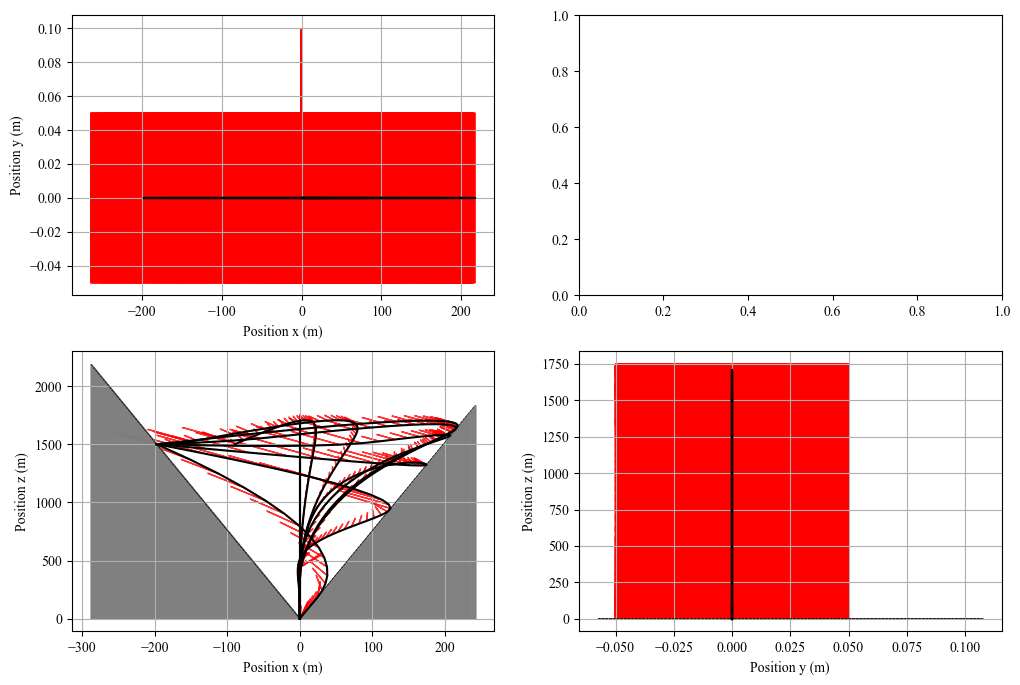

In [6]:
fig, axs = None, None
for i in range(len(thetas)):
    fig, axs = plot_3sides(t[:-1], x_profiles[i], u_profiles[i], uskip=1, gsa=lander.gsa, fig=fig, axs=axs)

plt.show()